In [0]:
import gym
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
import sys
from torch.autograd import Variable

In [0]:
GAMMA = 0.99

In [0]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def backward(policy, prob, action, state): 

    #policy is matrix of weights [dim state, nActions]
    grad = np.zeros(policy.shape)


    grad = -np.exp(prob[action])*np.exp(prob[:,None])*state[None,:]/(np.sum(np.exp(prob)))**2
    grad[action,:] = (np.exp(prob[action]*state[None,:]*(np.sum(np.exp(prob))-np.exp(prob[action]))))/(np.sum(np.exp(prob)))**2
    
    # for i in range(grad.shape[0]):
    #  for k in range(grad.shape[1]):
    #        #print('({}, {})'.format(i, k))
    #        if i == action:
    #            #print((np.exp(prob[action]*state[k]*(np.sum(np.exp(prob))-np.exp(prob[action]))))/(np.sum(np.exp(prob)))**2)
    #            grad[i][k] = (np.exp(prob[action]*state[k]*(np.sum(np.exp(prob))-np.exp(prob[action]))))/(np.sum(np.exp(prob)))**2
    #        elif i != action:
    #            #print(-np.exp(prob[action])*np.exp(prob[i])*state[k]/(np.sum(np.exp(prob)))**2)
    #            grad[i][k] = -np.exp(prob[action])*np.exp(prob[i])*state[k]/(np.sum(np.exp(prob)))**2

    return grad 

In [0]:
def align_columns_zeros(array):
    max_length = max(list(map(lambda x: len(x), array)))
    for col in range(len(array)):
        array[col] = np.pad(array[col], max_length - len(array[col]), 'constant', constant_values = 0)[max_length - len(array[col]):]
    return array

In [0]:
def trajectory_policy(policy, probs, rewards, actions, states):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / (np.std(discounted_rewards) + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for prob, Gt, action, state in zip(probs, discounted_rewards, actions, states):
        policy_gradient.append(1/prob[action] * backward(policy, prob, action, state) * Gt)
    policy_gradient = np.sum(policy_gradient, axis = 0)
    return policy_gradient

In [0]:
def cart_pole(n_trajectories = 2, episode_num = 1500, learning_rate = 9e-3):
    env = gym.make('CartPole-v0')
    num_actions = env.action_space.n
    max_episode_num = episode_num
    max_steps = 10000
    numsteps = [[] for i in range(n_trajectories)]
    avg_numsteps = [[] for i in range(n_trajectories)]
    all_rewards = [[] for i in range(n_trajectories)]
    policy = np.random.random_sample((env.observation_space.shape[0], env.action_space.n)).T

    for episode in range(1, max_episode_num + 1):
        r_gradient = []
        rewards = [[] for i in range(n_trajectories)]
        
        for trajectory in range(n_trajectories):
            state = env.reset()
            log_probs = []
            ps = []
            actions = []
            states = []
            
            for steps in range(max_steps):
                probs = softmax(np.dot(policy, state))       
                action = np.random.choice(num_actions, p = np.squeeze(probs))
                log_prob = np.log(np.squeeze(probs)[action])
                new_state, reward, done, _ = env.step(action)
                actions.append(action)
                ps.append(np.squeeze(probs))
                states.append(np.squeeze(state))
                log_probs.append(log_prob)
                rewards[trajectory].append(reward)
                
                if done:
                    traj = trajectory_policy(policy, ps, rewards[trajectory], actions, states)        
                    r_gradient.append(traj)
                    numsteps[trajectory].append(steps)
                    avg_numsteps[trajectory].append(np.mean(numsteps[trajectory][-10:]))
                    all_rewards[trajectory].append(np.sum(rewards[trajectory]))
                    break

                state = new_state

        policy_gradient = np.mean(r_gradient, axis = 0)
        policy += policy_gradient * learning_rate
        rewards = align_columns_zeros(rewards)
        if episode % 10 == 0:
            sys.stdout.write("episode: {}, total mean reward among trajectories: {}, average_reward_among_trajectories: {}\n".\
                                     format(episode, np.round(np.mean(np.sum(rewards, axis = 1)), decimals = 3),\
                                            np.round(np.mean(np.mean(all_rewards, axis = 0)[-10:]), decimals = 3)))
        
    return policy, all_rewards, avg_numsteps

In [75]:
%%time
statistics_all = [] 
statistics_mean = []
for game in tqdm(range(10)):
  _, all_rewards, mean_rewards = cart_pole(3, 1000, learning_rate=0.02)
  statistics_all.append(all_rewards)
  statistics_mean.append(mean_rewards)



























  0%|          | 0/10 [00:00<?, ?it/s]

episode: 10, total mean reward among trajectories: 31.333, average_reward_among_trajectories: 28.8
episode: 20, total mean reward among trajectories: 40.0, average_reward_among_trajectories: 32.233
episode: 30, total mean reward among trajectories: 65.667, average_reward_among_trajectories: 26.633
episode: 40, total mean reward among trajectories: 26.667, average_reward_among_trajectories: 38.6
episode: 50, total mean reward among trajectories: 29.667, average_reward_among_trajectories: 58.4
episode: 60, total mean reward among trajectories: 84.667, average_reward_among_trajectories: 73.267
episode: 70, total mean reward among trajectories: 56.667, average_reward_among_trajectories: 99.933
episode: 80, total mean reward among trajectories: 89.667, average_reward_among_trajectories: 92.667
episode: 90, total mean reward among trajectories: 117.0, average_reward_among_trajectories: 105.9
episode: 100, total mean reward among trajectories: 99.0, average_reward_among_trajectories: 138.933




























 10%|█         | 1/10 [01:07<10:05, 67.31s/it]

episode: 1000, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 199.433
episode: 10, total mean reward among trajectories: 19.667, average_reward_among_trajectories: 14.8
episode: 20, total mean reward among trajectories: 16.0, average_reward_among_trajectories: 19.6
episode: 30, total mean reward among trajectories: 29.333, average_reward_among_trajectories: 20.467
episode: 40, total mean reward among trajectories: 41.667, average_reward_among_trajectories: 32.7
episode: 50, total mean reward among trajectories: 85.0, average_reward_among_trajectories: 47.4
episode: 60, total mean reward among trajectories: 83.333, average_reward_among_trajectories: 46.167
episode: 70, total mean reward among trajectories: 47.0, average_reward_among_trajectories: 49.533
episode: 80, total mean reward among trajectories: 42.667, average_reward_among_trajectories: 44.233
episode: 90, total mean reward among trajectories: 32.667, average_reward_among_trajectories: 52.9
epis



























 20%|██        | 2/10 [02:13<08:54, 66.86s/it]

episode: 1000, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 198.667
episode: 10, total mean reward among trajectories: 20.0, average_reward_among_trajectories: 15.433
episode: 20, total mean reward among trajectories: 16.667, average_reward_among_trajectories: 19.233
episode: 30, total mean reward among trajectories: 25.333, average_reward_among_trajectories: 21.167
episode: 40, total mean reward among trajectories: 25.667, average_reward_among_trajectories: 21.1
episode: 50, total mean reward among trajectories: 15.667, average_reward_among_trajectories: 18.2
episode: 60, total mean reward among trajectories: 26.667, average_reward_among_trajectories: 20.367
episode: 70, total mean reward among trajectories: 44.333, average_reward_among_trajectories: 32.767
episode: 80, total mean reward among trajectories: 41.667, average_reward_among_trajectories: 50.033
episode: 90, total mean reward among trajectories: 43.0, average_reward_among_trajectories: 49.



























 30%|███       | 3/10 [03:16<07:40, 65.71s/it]

episode: 1000, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 198.6
episode: 10, total mean reward among trajectories: 20.667, average_reward_among_trajectories: 19.2
episode: 20, total mean reward among trajectories: 24.333, average_reward_among_trajectories: 18.533
episode: 30, total mean reward among trajectories: 37.333, average_reward_among_trajectories: 27.733
episode: 40, total mean reward among trajectories: 28.0, average_reward_among_trajectories: 27.033
episode: 50, total mean reward among trajectories: 41.0, average_reward_among_trajectories: 34.3
episode: 60, total mean reward among trajectories: 34.333, average_reward_among_trajectories: 36.733
episode: 70, total mean reward among trajectories: 22.0, average_reward_among_trajectories: 38.767
episode: 80, total mean reward among trajectories: 32.667, average_reward_among_trajectories: 44.867
episode: 90, total mean reward among trajectories: 30.0, average_reward_among_trajectories: 45.6
epis



























 40%|████      | 4/10 [04:13<06:19, 63.20s/it]

episode: 1000, total mean reward among trajectories: 156.333, average_reward_among_trajectories: 158.067
episode: 10, total mean reward among trajectories: 43.333, average_reward_among_trajectories: 34.0
episode: 20, total mean reward among trajectories: 23.667, average_reward_among_trajectories: 45.9
episode: 30, total mean reward among trajectories: 119.0, average_reward_among_trajectories: 67.633
episode: 40, total mean reward among trajectories: 59.0, average_reward_among_trajectories: 76.033
episode: 50, total mean reward among trajectories: 87.0, average_reward_among_trajectories: 92.733
episode: 60, total mean reward among trajectories: 128.667, average_reward_among_trajectories: 136.8
episode: 70, total mean reward among trajectories: 122.333, average_reward_among_trajectories: 111.933
episode: 80, total mean reward among trajectories: 108.333, average_reward_among_trajectories: 117.933
episode: 90, total mean reward among trajectories: 169.0, average_reward_among_trajectories:



























 50%|█████     | 5/10 [05:15<05:14, 62.82s/it]

episode: 1000, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 188.933
episode: 10, total mean reward among trajectories: 37.667, average_reward_among_trajectories: 32.167
episode: 20, total mean reward among trajectories: 87.333, average_reward_among_trajectories: 49.467
episode: 30, total mean reward among trajectories: 97.667, average_reward_among_trajectories: 59.967
episode: 40, total mean reward among trajectories: 84.333, average_reward_among_trajectories: 60.9
episode: 50, total mean reward among trajectories: 103.333, average_reward_among_trajectories: 66.667
episode: 60, total mean reward among trajectories: 66.333, average_reward_among_trajectories: 73.933
episode: 70, total mean reward among trajectories: 118.333, average_reward_among_trajectories: 84.1
episode: 80, total mean reward among trajectories: 47.0, average_reward_among_trajectories: 76.7
episode: 90, total mean reward among trajectories: 123.333, average_reward_among_trajectories: 



























 60%|██████    | 6/10 [06:24<04:18, 64.72s/it]

episode: 1000, total mean reward among trajectories: 175.333, average_reward_among_trajectories: 196.333
episode: 10, total mean reward among trajectories: 31.0, average_reward_among_trajectories: 35.833
episode: 20, total mean reward among trajectories: 40.0, average_reward_among_trajectories: 40.0
episode: 30, total mean reward among trajectories: 56.667, average_reward_among_trajectories: 40.867
episode: 40, total mean reward among trajectories: 76.0, average_reward_among_trajectories: 63.233
episode: 50, total mean reward among trajectories: 38.333, average_reward_among_trajectories: 43.433
episode: 60, total mean reward among trajectories: 63.667, average_reward_among_trajectories: 71.233
episode: 70, total mean reward among trajectories: 69.333, average_reward_among_trajectories: 70.9
episode: 80, total mean reward among trajectories: 82.667, average_reward_among_trajectories: 75.767
episode: 90, total mean reward among trajectories: 57.333, average_reward_among_trajectories: 84.



























 70%|███████   | 7/10 [07:29<03:14, 64.69s/it]

episode: 1000, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 193.5
episode: 10, total mean reward among trajectories: 24.667, average_reward_among_trajectories: 20.967
episode: 20, total mean reward among trajectories: 17.0, average_reward_among_trajectories: 21.233
episode: 30, total mean reward among trajectories: 20.333, average_reward_among_trajectories: 31.6
episode: 40, total mean reward among trajectories: 25.667, average_reward_among_trajectories: 33.133
episode: 50, total mean reward among trajectories: 44.0, average_reward_among_trajectories: 33.6
episode: 60, total mean reward among trajectories: 36.667, average_reward_among_trajectories: 39.8
episode: 70, total mean reward among trajectories: 78.333, average_reward_among_trajectories: 46.667
episode: 80, total mean reward among trajectories: 32.333, average_reward_among_trajectories: 40.433
episode: 90, total mean reward among trajectories: 40.333, average_reward_among_trajectories: 45.567




























 80%|████████  | 8/10 [08:36<02:10, 65.50s/it]

episode: 1000, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 198.733
episode: 10, total mean reward among trajectories: 21.333, average_reward_among_trajectories: 24.567
episode: 20, total mean reward among trajectories: 36.333, average_reward_among_trajectories: 28.367
episode: 30, total mean reward among trajectories: 66.0, average_reward_among_trajectories: 39.533
episode: 40, total mean reward among trajectories: 54.0, average_reward_among_trajectories: 52.2
episode: 50, total mean reward among trajectories: 60.333, average_reward_among_trajectories: 56.7
episode: 60, total mean reward among trajectories: 69.0, average_reward_among_trajectories: 53.567
episode: 70, total mean reward among trajectories: 47.667, average_reward_among_trajectories: 58.633
episode: 80, total mean reward among trajectories: 78.0, average_reward_among_trajectories: 58.733
episode: 90, total mean reward among trajectories: 96.333, average_reward_among_trajectories: 65.133




























 90%|█████████ | 9/10 [09:37<01:04, 64.12s/it]

episode: 1000, total mean reward among trajectories: 165.0, average_reward_among_trajectories: 147.433
episode: 10, total mean reward among trajectories: 25.0, average_reward_among_trajectories: 29.233
episode: 20, total mean reward among trajectories: 19.0, average_reward_among_trajectories: 32.8
episode: 30, total mean reward among trajectories: 64.667, average_reward_among_trajectories: 40.233
episode: 40, total mean reward among trajectories: 28.0, average_reward_among_trajectories: 48.033
episode: 50, total mean reward among trajectories: 51.333, average_reward_among_trajectories: 53.9
episode: 60, total mean reward among trajectories: 34.667, average_reward_among_trajectories: 56.867
episode: 70, total mean reward among trajectories: 62.0, average_reward_among_trajectories: 56.933
episode: 80, total mean reward among trajectories: 49.0, average_reward_among_trajectories: 54.3
episode: 90, total mean reward among trajectories: 79.333, average_reward_among_trajectories: 74.333
epis



























100%|██████████| 10/10 [10:40<00:00, 64.04s/it]

episode: 1000, total mean reward among trajectories: 152.333, average_reward_among_trajectories: 129.833
CPU times: user 10min 43s, sys: 7.39 s, total: 10min 50s
Wall time: 10min 40s


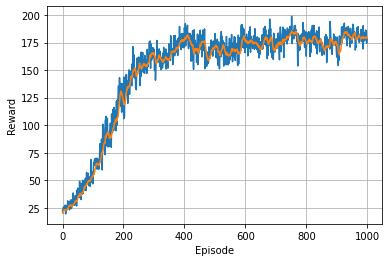

Varince of reward = 2138.926880861111


In [85]:
plt.plot(np.mean(np.mean(statistics_all, axis = 1), axis = 0))
plt.plot(np.mean(np.mean(statistics_mean, axis = 1), axis = 0))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid()
plt.show()
print('Varince of reward = {}'.format(np.var(np.mean(np.mean(statistics_all, axis = 1), axis = 0))))

In [0]:
df = pd.DataFrame()
df['rewards'] = np.mean(np.mean(statistics_all, axis = 1), axis = 0)
df['mean10_rewards'] = np.mean(np.mean(statistics_mean, axis = 1), axis = 0)
df.to_csv('/content/softmax_0-02-3traj', index=False)

In [0]:
%%time
GAMMA = 0.99
learning_rate = 0.003
env = gym.make('CartPole-v0')

num_actions = env.action_space.n
max_episode_num = 2000
max_steps = 10000
numsteps = []
avg_numsteps = []
all_rewards = []
policy = np.random.random_sample((env.observation_space.shape[0], env.action_space.n)).T
print(policy)

for episode in range(max_episode_num):
    state = env.reset().reshape(-1, 1)
    ps = []
    log_probs = []
    rewards = []
    actions = []
    states = []

    for steps in range(max_steps):
        #env.render()
        probs = softmax(np.dot(policy, state))
        action = np.random.choice(num_actions, p = np.squeeze(probs))
        log_prob = np.log(np.squeeze(probs)[action])
        new_state, reward, done, _ = env.step(action)
        actions.append(action)
        ps.append(np.squeeze(probs))
        states.append(np.squeeze(state))
        log_probs.append(log_prob)
        rewards.append(reward)

        if done:
            update_policy(policy, ps, rewards, actions, states)
            numsteps.append(steps)
            avg_numsteps.append(np.mean(numsteps[-10:]))
            all_rewards.append(np.sum(rewards))
            if episode % 10 == 0:
                print("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
            break 
        state = new_state

# BASELINE

In [0]:
class ValueNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=5e-4):
        super(ValueNetwork, self).__init__()

        self.num_actions = num_actions
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        #self.linear = nn.Linear(num_inputs, 1)
        self.linear2 = nn.Linear(hidden_size, 1)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    
    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.linear1(state))
        value = self.linear2(value)
        return value

In [0]:
def count_trajectory_for_baseline(rewards, log_probs_deriv, baseline):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = torch.tensor(discounted_rewards)
    discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for log_prob_deriv, Gt, bs in zip(log_probs_deriv, discounted_rewards, baseline):
        if log_prob_deriv == 0:
            policy_gradient.append(torch.tensor([0.0], requires_grad = True))
        else:
            term = bs.resize(1)
            term = term - Gt
            term = term**2
            term = term * log_prob_deriv
            #policy_gradient.append(torch.tensor([log_prob_deriv * (Gt - bs.resize(1))**2], requires_grad = True))
            policy_gradient.append(term)
    policy_gradient = torch.stack(policy_gradient).sum()
    return policy_gradient

In [0]:
def baseline_approximation(policy, value_net, n_trajectories, n_epoch = 4000, early_stopping_rounds = 250):
    num_actions = env.action_space.n
    max_steps = 10000
    min_loss = float('inf')
    stopping_rounds = 0
    epoch = 1
    value_loss_list = []
    
    rewards = [[] for i in range(n_trajectories)]
    log_probs_deriv = [[] for i in range(n_trajectories)]

    states = [[] for i in range(n_trajectories)]
    
    for trajectory in range(n_trajectories):
        state = env.reset()
            
        for steps in range(max_steps):
            
            probs = softmax(np.dot(policy, state))
            action = np.random.choice(num_actions, p = np.squeeze(probs))
            new_state, reward, done, _ = env.step(action)
            
            states[trajectory].append(state)
            prob = np.squeeze(probs)
            log_probs_deriv[trajectory].append(np.sum((1/prob[action] * backward(policy, prob, action, state))**2))
            rewards[trajectory].append(reward)
            if done:                    
                break
            state = new_state

    rewards = align_columns_zeros(rewards)
    log_probs_deriv = align_columns_zeros(log_probs_deriv)

    while(stopping_rounds < early_stopping_rounds and epoch < n_epoch):
        r_gradient = []
        baseline_values = [[] for i in range(n_trajectories)]

        for trajectory in range(n_trajectories):
            for state in states[trajectory]:
                baseline = value_net.forward(state)
                baseline_values[trajectory].append(baseline)
        baseline_values = align_columns_zeros(baseline_values)
        for col in range(len(rewards)):
            traj = count_trajectory_for_baseline(rewards[col], log_probs_deriv[col], baseline_values[col])
            r_gradient.append(traj)

        r_gradient = torch.stack(r_gradient)
        value_loss = r_gradient.mean()
        value_loss_list.append(value_loss.detach())
        if value_loss < min_loss:
            min_loss = value_loss
            torch.save(value_net, 'model.pth')
            print('{}. Current minimum value loss = {}'.format(epoch, value_loss))
            stopping_rounds = 0
        else:
            stopping_rounds += 1
        #print('{}. Current value loss = {}, min value_loss = {}, stopping_round = {}'.format(epoch, value_loss, min_loss, stopping_rounds))
        epoch += 1
        value_net.optimizer.zero_grad()
        value_loss.backward()
        value_net.optimizer.step()
    value_net = torch.load('model.pth')
    return value_loss_list

In [98]:
%%time
env = gym.make('CartPole-v0')
value_net = ValueNetwork(env.observation_space.shape[0], env.action_space.n, 256)
#policy = np.random.random_sample((env.observation_space.shape[0], env.action_space.n)).T
lst_loss = baseline_approximation(policy, value_net, 5, n_epoch = 50, early_stopping_rounds=150)

/usr/local/lib/python3.6/dist-packages/torch/tensor.py:362: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type ValueNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


1. Current minimum value loss = 14.289892196655273
2. Current minimum value loss = 14.04932689666748
3. Current minimum value loss = 13.819055557250977
4. Current minimum value loss = 13.599146842956543
5. Current minimum value loss = 13.389493942260742
6. Current minimum value loss = 13.18998908996582
7. Current minimum value loss = 13.000348091125488
8. Current minimum value loss = 12.820220947265625
9. Current minimum value loss = 12.649240493774414
10. Current minimum value loss = 12.486955642700195
11. Current minimum value loss = 12.332976341247559
12. Current minimum value loss = 12.186777114868164
13. Current minimum value loss = 12.047834396362305
14. Current minimum value loss = 11.91556453704834
15. Current minimum value loss = 11.78942584991455
16. Current minimum value loss = 11.668792724609375
17. Current minimum value loss = 11.553147315979004
18. Current minimum value loss = 11.441972732543945
19. Current minimum value loss = 11.33472728729248
20. Current minimum value 

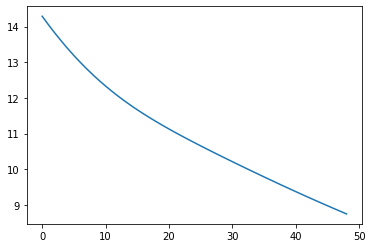

In [99]:
plt.plot(lst_loss)

In [0]:
def trajectory_policy_baseline(probs, rewards, actions, states, baselines):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / (np.std(discounted_rewards) + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for prob, Gt, action, bs, state in zip(probs, discounted_rewards, actions, baselines, states):
        policy_gradient.append(1/prob[action] * backward(policy, prob, action, state) * (Gt - bs.detach().numpy()))
    policy_gradient = np.sum(policy_gradient, axis = 0)
    return policy_gradient

In [0]:
def cart_pole_baseline(value_net, n_trajectories = 2, episode_num = 1000, baseline_retrain = False, retrain_episodes = 50, learning_rate = 2e-2):

    env = gym.make('CartPole-v0')
    num_actions = env.action_space.n
    max_episode_num = episode_num
    max_steps = 10000
    numsteps = [[] for i in range(n_trajectories)]
    avg_numsteps = [[] for i in range(n_trajectories)]
    all_rewards = [[] for i in range(n_trajectories)]
    policy = np.random.random_sample((env.observation_space.shape[0], env.action_space.n)).T

    for episode in range(1, max_episode_num + 1):
        r_gradient = []
        rewards = [[] for i in range(n_trajectories)]
        baseline_values = []
        
        for trajectory in range(n_trajectories):
            state = env.reset()
            log_probs = []
            ps = []
            actions = []
            states = []
            
            for steps in range(max_steps):

                baseline = value_net.forward(state)
                probs = softmax(np.dot(policy, state))       
                action = np.random.choice(num_actions, p = np.squeeze(probs))
                log_prob = np.log(np.squeeze(probs)[action])
                new_state, reward, done, _ = env.step(action)
                actions.append(action)
                ps.append(np.squeeze(probs))
                states.append(np.squeeze(state))
                log_probs.append(log_prob)
                rewards[trajectory].append(reward)
                baseline_values.append(baseline)
                
                if done:
                    traj = trajectory_policy_baseline(ps, rewards[trajectory], actions, states, baseline_values)                       
                    r_gradient.append(traj)
                    numsteps[trajectory].append(steps)
                    avg_numsteps[trajectory].append(np.mean(numsteps[trajectory][-10:]))
                    all_rewards[trajectory].append(np.sum(rewards[trajectory]))
                    break

                state = new_state

        policy_gradient = np.mean(r_gradient, axis = 0)
        policy += policy_gradient * learning_rate
        rewards = align_columns_zeros(rewards)
        if episode % 10 == 0:
            sys.stdout.write("episode: {}, total mean reward among trajectories: {}, average_reward_among_trajectories: {}\n".\
                                     format(episode, np.round(np.mean(np.sum(rewards, axis = 1)), decimals = 3),\
                                            np.round(np.mean(np.mean(all_rewards, axis = 0)[-10:]), decimals = 3)))
            
        if baseline_retrain == True:
            if episode % retrain_episodes == 0:
                baseline_approximation(policy_net, value_net, 3, n_epoch = 1000, early_stopping_rounds=10)
        
    return all_rewards, avg_numsteps

In [0]:
%%time
statistics_all = []
statistics_mean = []
for game in tqdm(range(10)):
  all_rewards, mean_rewards = cart_pole_baseline(value_net, 3, learning_rate = 0.03)
  statistics_all.append(all_rewards)
  statistics_mean.append(mean_rewards)



























  0%|          | 0/10 [00:00<?, ?it/s]

episode: 10, total mean reward among trajectories: 16.667, average_reward_among_trajectories: 19.633
episode: 20, total mean reward among trajectories: 35.667, average_reward_among_trajectories: 38.967
episode: 30, total mean reward among trajectories: 23.667, average_reward_among_trajectories: 39.6
episode: 40, total mean reward among trajectories: 75.667, average_reward_among_trajectories: 48.267
episode: 50, total mean reward among trajectories: 86.333, average_reward_among_trajectories: 69.667
episode: 60, total mean reward among trajectories: 57.333, average_reward_among_trajectories: 82.7
episode: 70, total mean reward among trajectories: 120.333, average_reward_among_trajectories: 88.133
episode: 80, total mean reward among trajectories: 142.667, average_reward_among_trajectories: 107.867
episode: 90, total mean reward among trajectories: 121.667, average_reward_among_trajectories: 85.767
episode: 100, total mean reward among trajectories: 134.0, average_reward_among_trajectorie



























 10%|█         | 1/10 [02:13<19:58, 133.16s/it]

episode: 1000, total mean reward among trajectories: 200.0, average_reward_among_trajectories: 187.733
episode: 10, total mean reward among trajectories: 20.667, average_reward_among_trajectories: 25.533
episode: 20, total mean reward among trajectories: 38.667, average_reward_among_trajectories: 33.667
episode: 30, total mean reward among trajectories: 44.0, average_reward_among_trajectories: 36.433
episode: 40, total mean reward among trajectories: 26.667, average_reward_among_trajectories: 42.133
episode: 50, total mean reward among trajectories: 45.333, average_reward_among_trajectories: 43.767
episode: 60, total mean reward among trajectories: 37.333, average_reward_among_trajectories: 40.9
episode: 70, total mean reward among trajectories: 39.0, average_reward_among_trajectories: 40.533
episode: 80, total mean reward among trajectories: 50.667, average_reward_among_trajectories: 53.6
episode: 90, total mean reward among trajectories: 47.333, average_reward_among_trajectories: 41.



























 20%|██        | 2/10 [04:00<16:42, 125.36s/it]

episode: 1000, total mean reward among trajectories: 158.333, average_reward_among_trajectories: 181.633
episode: 10, total mean reward among trajectories: 20.667, average_reward_among_trajectories: 20.967
episode: 20, total mean reward among trajectories: 19.0, average_reward_among_trajectories: 24.733
episode: 30, total mean reward among trajectories: 30.333, average_reward_among_trajectories: 21.833
episode: 40, total mean reward among trajectories: 51.333, average_reward_among_trajectories: 32.933
episode: 50, total mean reward among trajectories: 27.333, average_reward_among_trajectories: 35.667
episode: 60, total mean reward among trajectories: 64.667, average_reward_among_trajectories: 50.933
episode: 70, total mean reward among trajectories: 60.333, average_reward_among_trajectories: 51.633
episode: 80, total mean reward among trajectories: 42.0, average_reward_among_trajectories: 42.4
episode: 90, total mean reward among trajectories: 22.0, average_reward_among_trajectories: 4



























 30%|███       | 3/10 [05:59<14:23, 123.43s/it]

episode: 1000, total mean reward among trajectories: 162.333, average_reward_among_trajectories: 132.267
episode: 10, total mean reward among trajectories: 57.333, average_reward_among_trajectories: 35.067
episode: 20, total mean reward among trajectories: 42.667, average_reward_among_trajectories: 40.333
episode: 30, total mean reward among trajectories: 25.0, average_reward_among_trajectories: 42.467
episode: 40, total mean reward among trajectories: 42.0, average_reward_among_trajectories: 39.1
episode: 50, total mean reward among trajectories: 27.667, average_reward_among_trajectories: 41.733
episode: 60, total mean reward among trajectories: 24.333, average_reward_among_trajectories: 45.967
episode: 70, total mean reward among trajectories: 99.333, average_reward_among_trajectories: 58.8
episode: 80, total mean reward among trajectories: 67.0, average_reward_among_trajectories: 67.867
episode: 90, total mean reward among trajectories: 104.0, average_reward_among_trajectories: 81.9



























 40%|████      | 4/10 [08:05<12:25, 124.24s/it]

episode: 1000, total mean reward among trajectories: 186.333, average_reward_among_trajectories: 171.533
episode: 10, total mean reward among trajectories: 52.333, average_reward_among_trajectories: 42.867
episode: 20, total mean reward among trajectories: 37.0, average_reward_among_trajectories: 52.4
episode: 30, total mean reward among trajectories: 88.0, average_reward_among_trajectories: 60.567
episode: 40, total mean reward among trajectories: 86.667, average_reward_among_trajectories: 62.1
episode: 50, total mean reward among trajectories: 89.333, average_reward_among_trajectories: 58.6
episode: 60, total mean reward among trajectories: 105.333, average_reward_among_trajectories: 77.9
episode: 70, total mean reward among trajectories: 127.0, average_reward_among_trajectories: 90.933
episode: 80, total mean reward among trajectories: 96.333, average_reward_among_trajectories: 90.733
episode: 90, total mean reward among trajectories: 105.0, average_reward_among_trajectories: 89.667



























 50%|█████     | 5/10 [10:08<10:20, 124.03s/it]

episode: 1000, total mean reward among trajectories: 163.333, average_reward_among_trajectories: 166.1
episode: 10, total mean reward among trajectories: 59.0, average_reward_among_trajectories: 34.8
episode: 20, total mean reward among trajectories: 47.333, average_reward_among_trajectories: 41.133
episode: 30, total mean reward among trajectories: 58.0, average_reward_among_trajectories: 48.3
episode: 40, total mean reward among trajectories: 53.0, average_reward_among_trajectories: 51.433
episode: 50, total mean reward among trajectories: 58.667, average_reward_among_trajectories: 58.6
episode: 60, total mean reward among trajectories: 57.0, average_reward_among_trajectories: 80.3
episode: 70, total mean reward among trajectories: 102.333, average_reward_among_trajectories: 96.1
episode: 80, total mean reward among trajectories: 110.333, average_reward_among_trajectories: 88.6
episode: 90, total mean reward among trajectories: 67.333, average_reward_among_trajectories: 98.8
episode:

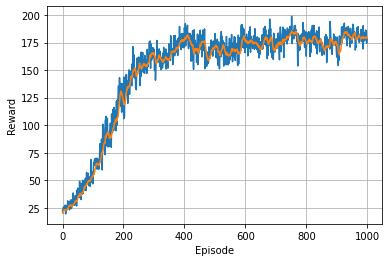

Varince of reward = 2138.926880861111


In [86]:
plt.plot(np.mean(np.mean(statistics_all, axis = 1), axis = 0))
plt.plot(np.mean(np.mean(statistics_mean, axis = 1), axis = 0))
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.grid()
plt.show()
print('Varince of reward = {}'.format(np.var(np.mean(np.mean(statistics_all, axis = 1), axis = 0))))

In [0]:
df = pd.DataFrame()
df['rewards'] = np.mean(np.mean(statistics_all, axis = 1), axis = 0)
df['mean10_rewards'] = np.mean(np.mean(statistics_mean, axis = 1), axis = 0)
df.to_csv('/content/softmax_0-02-3traj_baseline_2layers_5traj_50epochs_0-0005', index=False)

In [0]:
%%time
GAMMA = 0.99
learning_rate = 0.003
env = gym.make('CartPole-v0')

num_actions = env.action_space.n
max_episode_num = 2000
max_steps = 10000
numsteps = []
avg_numsteps = []
all_rewards = []
policy = np.random.random_sample((env.observation_space.shape[0], env.action_space.n)).T

for episode in range(max_episode_num):
    state = env.reset()
    ps = []
    log_probs = []
    rewards = []
    actions = []
    states = []
    baselines = []

    for steps in range(max_steps):
        #env.render()
        baseline = value_net.forward(state)
        probs = softmax(np.dot(policy, state))       
        action = np.random.choice(num_actions, p = np.squeeze(probs))
        log_prob = np.log(np.squeeze(probs)[action])
        new_state, reward, done, _ = env.step(action)
        actions.append(action)
        ps.append(np.squeeze(probs))
        states.append(np.squeeze(state))
        log_probs.append(log_prob)
        rewards.append(reward)
        baselines.append(baseline)

        if done:
            update_policy_baseline(policy, ps, rewards, actions, states, baselines)
            numsteps.append(steps)
            avg_numsteps.append(np.mean(numsteps[-10:]))
            all_rewards.append(np.sum(rewards))
            if episode % 10 == 0:
                print("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
            break 
        state = new_state

episode: 0, total reward: 37.0, average_reward: 37.0, length: 36

episode: 10, total reward: 15.0, average_reward: 35.4, length: 14

episode: 20, total reward: 29.0, average_reward: 27.9, length: 28

episode: 30, total reward: 26.0, average_reward: 26.5, length: 25

episode: 40, total reward: 30.0, average_reward: 29.8, length: 29

episode: 50, total reward: 14.0, average_reward: 26.3, length: 13

episode: 60, total reward: 24.0, average_reward: 33.5, length: 23

episode: 70, total reward: 21.0, average_reward: 35.0, length: 20

episode: 80, total reward: 29.0, average_reward: 37.7, length: 28

episode: 90, total reward: 33.0, average_reward: 24.6, length: 32

episode: 100, total reward: 34.0, average_reward: 28.7, length: 33

episode: 110, total reward: 46.0, average_reward: 55.0, length: 45

episode: 120, total reward: 72.0, average_reward: 44.4, length: 71

episode: 130, total reward: 16.0, average_reward: 25.4, length: 15

episode: 140, total reward: 33.0, average_reward: 49.7, len

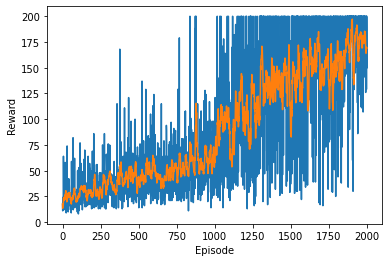

Varince of reward = 3923.05229775


In [0]:
plt.plot(all_rewards)
plt.plot(avg_numsteps)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('Varince of reward = {}'.format(np.var(all_rewards)))

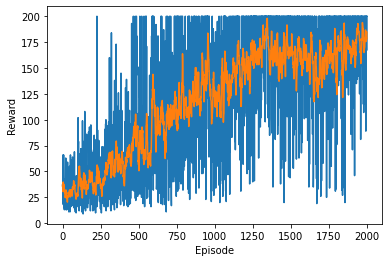

Varince of reward = 4137.19468775


In [0]:
plt.plot(all_rewards)
plt.plot(avg_numsteps)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('Varince of reward = {}'.format(np.var(all_rewards)))